In this notebook the plot for the activation energy as a function of Ca content is produced

In [1]:
#Hide warnings when logging
from tensorflow.compat.v1.logging import set_verbosity,ERROR
set_verbosity(ERROR) 

from Utils import *
from numpy import random

directory = 'models/' 

def doAll(hyper,stoichiom):  
    #Loads data and models, transforms and prepares all the final data (1/T and log(B/T**2))
    
    names = !ls data/*txt
    names = [file for file in names if file.split('/')[1][:5] in stoichiom]

    dfs = {}
    for name in names:
        df,NormPrms = LoadDF(name,dom=(210,600))     #Load data using same dom as that used in training
        DFiHyper = TransferHyper(df,hyper)    #Transfer model
        dfs[name] = (df,DFiHyper,NormPrms)
        print(f"{name} successfully loaded.")

    #Load all trained models:
    PRMS = {}

    for name in names:
        name = name.split('/')[-1]
        if name[:5] in stoichiom:
            file = directory + name[:5] + f'/SELECTED_{name}.hdf5'
            print(f"Loading selected model for {name}...")
            PRMS[name] = LoadModel(file,hyper)
    print("All models have been successfully loaded")
    
    
    #Build dicts containing extracted and transformed data
    X,Y = FeatureDict(PRMS,names,dfs,steqs=stoichiom,exponent = 2)
    
    return X,Y

Using TensorFlow backend.


In [2]:
stoichiom = ['La0.5','La0.7']  #Stoichiometries to be used

#This array is just to make things work, 
#can be anything but freezeS (last row) must be in accordance with the way the models were trained
hyper = random.random((6,6))
hyper[-1,:] = [0,0,0,1,1,0]


X,Y = doAll(hyper,stoichiom)

#Must treat La0.9 differently because all variables were unfreezed for this stoichiometry

stoichiom = ['La0.9']  #Stoichiometries to be used
hyper[-1,:] = [0,0,0,0,0,0]

X1,Y1 = doAll(hyper,stoichiom)

#Merge all in a single dict (X, Y)
X['0.9'] = X1['0.9']
Y['0.9'] = Y1['0.9']

data/La0.5Ca0.5NiO310C.txt successfully loaded.
data/La0.5Ca0.5NiO315C.txt successfully loaded.
data/La0.5Ca0.5NiO35C.txt successfully loaded.
data/La0.5Ca0.5NiO38C.txt successfully loaded.
data/La0.7Ca0.3NiO310C.txt successfully loaded.
data/La0.7Ca0.3NiO315C.txt successfully loaded.
data/La0.7Ca0.3NiO35C.txt successfully loaded.
data/La0.7Ca0.3NiO38C.txt successfully loaded.
Loading selected model for La0.5Ca0.5NiO310C.txt...
Loading selected model for La0.5Ca0.5NiO315C.txt...
Loading selected model for La0.5Ca0.5NiO35C.txt...
Loading selected model for La0.5Ca0.5NiO38C.txt...
Loading selected model for La0.7Ca0.3NiO310C.txt...
Loading selected model for La0.7Ca0.3NiO315C.txt...
Loading selected model for La0.7Ca0.3NiO35C.txt...
Loading selected model for La0.7Ca0.3NiO38C.txt...
All models have been successfully loaded
data/La0.9Ca0.1NiO310C.txt successfully loaded.
data/La0.9Ca0.1NiO315C.txt successfully loaded.
data/La0.9Ca0.1NiO35C.txt successfully loaded.
data/La0.9Ca0.1NiO38C.tx

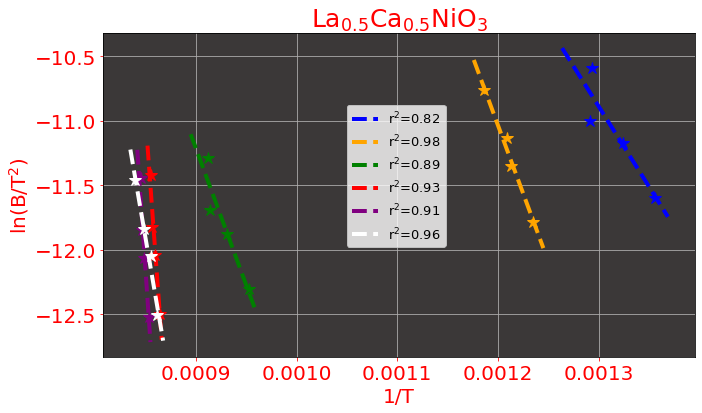

In [6]:
def PlotLinearModels(X,Y,save=False,xlims=False,textColor = 'w'):
    """If save!=False, it must contain the name with which the plot is to be saved.
    xlims is a tuple containing x limits of the plot"""
    steqs = list(X.keys())
    fig,ax = subplots(len(steqs),figsize=(10,6*len(steqs)),sharex=True)
    rcParams['font.size'] = 15
    colors = ['b','orange','green','red','purple','w']

    
    if len(steqs) == 1:
        ax = [ax]
        
    for j in range(len(steqs)):
        steq = steqs[j]
        ax[j].set_ylabel(r'ln(B/T$^2)$',color=textColor,fontsize=20)
        for i in range(6):
            x = X[steq][f's{i}']
            y = Y[steq][f's{i}']
            lr = linregress(x,y)
            f = poly1d(lr[:2])
            M,I = lr[:2]
            R = lr.rvalue**2
            ax[j].plot(x,y,'*',color=colors[i],markersize=13)
            xs = linspace(mean(x)-2*std(x),mean(x)+2*std(x))
            ax[j].plot(xs,f(xs),'--',color=colors[i], label = r'r$^2$={:.2f}'.format(R), #y = {M:.4E} x + {I:.2f}     
                       linewidth=4)
        
        if xlims:
            ax[j].set_xlim(xlims[0],xlims[1])
        
        ax[j].legend(bbox_to_anchor=(0.4, 0.3, 0.5, 0.5),fontsize=13)
        ax[j].set_facecolor('#3b3838ff')
        ax[j].grid()

    for i in range(len(steqs)):
        ax[i].set_title(r'La$_{0.5}$Ca$_{0.5}$NiO$_3$',color=textColor,fontsize=25)
        ax[i].tick_params(colors=textColor,labelsize=20)

    ax[-1].set_xlabel('1/T',color=textColor,fontsize=20)
    tight_layout()
    if save:
        savefig(save,dpi=300,bbox_inches='tight',facecolor=fig.get_facecolor())
        
    show()
    
    
PlotLinearModels({'0.5':X['0.5']},{'0.5':Y['0.5']},xlims=False,textColor = 'r')

In [7]:
def GetLinearModels(X,Y,R):
    
    steqs = list(X.keys())
    slopes = {}
    interc = {}
    for j in range(len(steqs)):
        steq = steqs[j]
        for i in range(6):
            x = X[steq][f's{i}']
            y = Y[steq][f's{i}']
            lr = linregress(x,y)
            f = poly1d(lr[:2])
            M,I = lr[:2]

            slopes[f'{steq}_E{i}'] = M * R
            interc[f'{steq}_E{i}'] = I
    return slopes,interc

slopes,interc = GetLinearModels(X,Y,R = -8.314472/1000 ) #R in kJ/mol-K 

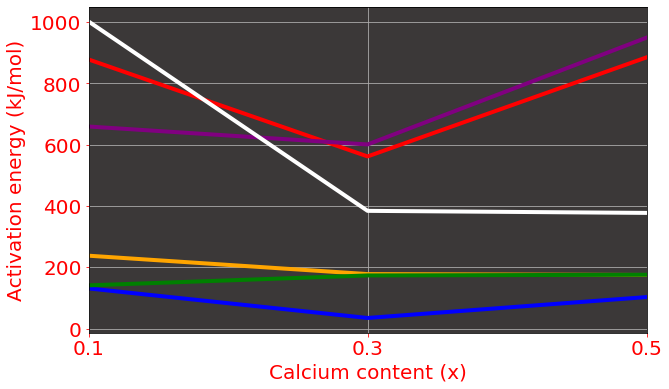

In [8]:
textColor='r'

#Now let's plot Ea
colors = ['b','orange','green','red','purple','w']

fig,ax = subplots(figsize=(10,6))
ax.set_xticks([0.1,0.3,0.5])
ax.grid()
ax.set_xlim(0.1,0.5)
ax.set_xlabel('Calcium content (x)',color=textColor,fontsize=20)
ax.set_ylabel('Activation energy (kJ/mol)',color=textColor,fontsize=20)

ax.set_facecolor('#3b3838ff')

for i in range(6):
    x = []
    y = []
    for stoich in X.keys():
        x.append(1-float(stoich))
        y.append(slopes[f'{stoich}_E{i}'])
        
    ax.plot(x,y,label = f'Event {i}',color=colors[i],linewidth=4)
    ax.tick_params(colors=textColor,labelsize=20)
    
#ax.legend(bbox_to_anchor=(0.72, 0.526, 0.5, 0.5))

#savefig('./CaContent.png',dpi=300,bbox_inches='tight',facecolor=fig.get_facecolor())
show()